## Mini Project_3: Simple Face Recognition ##
### Vaishali Shukla###
### Enrollment ID: 16325790 ##


In [40]:
# Importing necessary libraries
import os
import shutil
import random
import numpy as np
import pandas as pd
import cv2
from PIL import Image

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import SGD
from keras.layers import Dense
from keras.models import Model
from keras.applications.vgg19 import VGG19

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from keras.utils import plot_model

In [41]:
# mounting google drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [43]:
# uploading zip fle

from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive (1).zip


In [ ]:
#extracting zipped file in folder name new_folder

!unzip archive.zip -d /content/gdrive/MyDrive/DL_Project_3/new_folder

In [45]:
# set the paths to the original and new data directories
original_data_dir = '/content/gdrive/MyDrive/DL_Project_3/new_folder'
train_dir = '/content/gdrive/MyDrive/DL_Project_3/process_data/train'
test_dir = '/content/gdrive/MyDrive/DL_Project_3/process_data/test'
valid_dir = '/content/gdrive/MyDrive/DL_Project_3/process_data/valid'

# create the new data directories if they don't exist
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)
if not os.path.exists(valid_dir):
    os.makedirs(valid_dir)

In [46]:
# set the percentage split for train, test, and validation data

train_pct = 0.7
test_pct = 0.0
valid_pct = 0.3

# loop through the original data directories and split the images
# Converting images from greyscale to RGB and .pgm file extension to .png file extenstion

for person_dir in os.listdir(original_data_dir):
    person_path = os.path.join(original_data_dir, person_dir)
    if os.path.isdir(person_path):
        images = os.listdir(person_path)
        random.shuffle(images)
        num_train = int(len(images) * train_pct)
        num_test = int(len(images) * test_pct)
        num_valid = int(len(images) * valid_pct)
        train_images = images[:num_train]
        test_images = images[num_train:num_train+num_test]
        valid_images = images[num_train+num_test:num_train+num_test+num_valid]
        for image in train_images:
            src = os.path.join(person_path, image)
            dst = os.path.join(train_dir, person_dir, image.split('.')[0]+'.png')
            os.makedirs(os.path.join(train_dir, person_dir), exist_ok=True)
            img = Image.open(src).convert('RGB') # read the image in RGB format
            img.save(dst) # write the image to the new directory
        for image in test_images:
            src = os.path.join(person_path, image)
            dst = os.path.join(test_dir, person_dir, image.split('.')[0]+'.png')
            os.makedirs(os.path.join(test_dir, person_dir), exist_ok=True)
            img = Image.open(src).convert('RGB') # read the image in RGB format
            img.save(dst) # write the image to the new directory
        for image in valid_images:
            src = os.path.join(person_path, image)
            dst = os.path.join(valid_dir, person_dir, image.split('.')[0]+'.png')
            os.makedirs(os.path.join(valid_dir, person_dir), exist_ok=True)
            img = Image.open(src).convert('RGB') # read the image in RGB format
            img.save(dst) # write the image to the new directory

In [47]:
#checking total image in original dataset
import glob

original_data_dir = '/content/gdrive/MyDrive/DL_Project_3/new_folder'
image_count = len(glob.glob(os.path.join(original_data_dir, '**/*.pgm'), recursive=True))

print("Number of images in original data directory: ", image_count)

Number of images in original data directory:  400


In [60]:
# using 'ImageDataGenerator' to preprocess and image augmentation

train_data_generator = ImageDataGenerator(rescale=1./255) # normalizing and rescaling image pixel value betwen 0 and 1

train_data = train_data_generator.flow_from_directory(
        train_dir,
        target_size=(227, 227),                           #resizing image 
        batch_size=32,
        class_mode='categorical')                         #classes are one-hot vector encoded

images, labels = train_data.next()

class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)

image_shape = train_data.image_shape
print("Image shape: ", image_shape)

valid_data_generator = ImageDataGenerator(rescale=1./255)
valid_data = valid_data_generator.flow_from_directory(
        valid_dir,
        target_size=(227, 227),
        batch_size=32,
        class_mode='categorical')

images, labels = valid_data.next()

class_names = sorted(os.listdir(valid_dir))
num_classes = len(class_names)

image_shape = valid_data.image_shape
print("Image shape: ", image_shape)

Found 280 images belonging to 40 classes.
Image shape:  (227, 227, 3)
Found 120 images belonging to 40 classes.
Image shape:  (227, 227, 3)


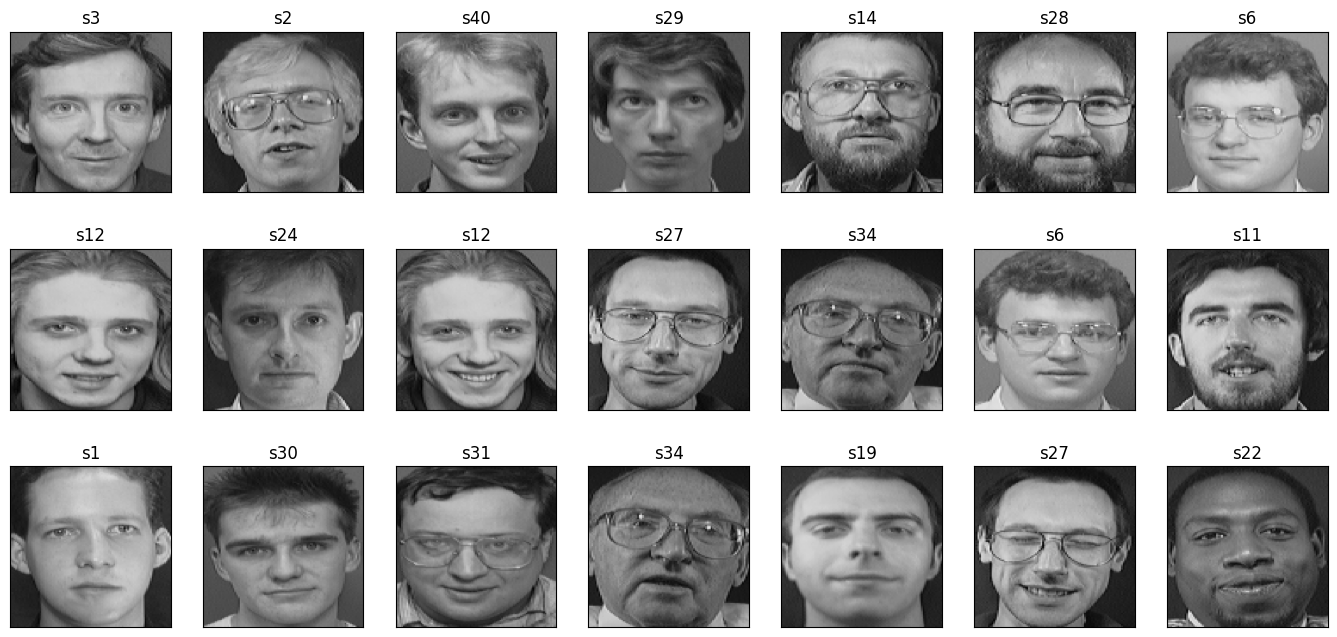

In [49]:
# Visualize Data
images, labels = train_data.next()

fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(17, 8))
index = 0
for i in range(3):
    for j in range(7):
        axes[i,j].set_title(class_names[labels[index].argmax()])
        axes[i,j].imshow(images[index])
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()


In [76]:
# Creating the CNN model

# Initializing a Sequential Model
cnn_model = Sequential()

# Add the first Convolutional block
cnn_model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (227,227,3)))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv2D(filters = 32, padding = 'same', kernel_size = (3,3), activation = 'relu'))
cnn_model.add(MaxPooling2D(2,2))

# Add the second Convolutional block
cnn_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(MaxPooling2D(2,2))

# Add the third Convolutional block
cnn_model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(MaxPooling2D(2,2))

# Add the Flatten layer
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.2))

# Add the first Dense layer
cnn_model.add(Dense(units = 1024, activation = 'relu'))
cnn_model.add(Dropout(0.2))

# Add the second Dense layer
cnn_model.add(Dense(units = 512, activation = 'relu'))
cnn_model.add(Dropout(0.2))

# Add the Final layer
cnn_model.add(Dense(units = 40, activation = 'softmax'))



In [77]:
# Compiling the Model

epochs = 20
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum = 0.9, decay = decay, nesterov=False)
cnn_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(cnn_model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 227, 227, 32)      896       
                                                                 
 dropout_30 (Dropout)        (None, 227, 227, 32)      0         
                                                                 
 conv2d_33 (Conv2D)          (None, 227, 227, 32)      9248      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 113, 113, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 113, 113, 64)      18496     
                                                                 
 dropout_31 (Dropout)        (None, 113, 113, 64)      0         
                                                      

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [78]:
# fitting the model

history = cnn_model.fit(train_data, validation_data = (valid_data), epochs=20, batch_size=32)

Epoch 1/20
9/9 [==============================] - 94s 10s/step - loss: 3.7070 - accuracy: 0.0179 - val_loss: 3.6838 - val_accuracy: 0.0500
Epoch 2/20
9/9 [==============================] - 93s 10s/step - loss: 3.6825 - accuracy: 0.0214 - val_loss: 3.6859 - val_accuracy: 0.0333
Epoch 3/20
9/9 [==============================] - 95s 11s/step - loss: 3.6438 - accuracy: 0.0429 - val_loss: 3.6399 - val_accuracy: 0.1583
Epoch 4/20
9/9 [==============================] - 93s 11s/step - loss: 3.4892 - accuracy: 0.0857 - val_loss: 3.4288 - val_accuracy: 0.2000
Epoch 5/20
9/9 [==============================] - 93s 10s/step - loss: 3.3035 - accuracy: 0.1357 - val_loss: 3.6679 - val_accuracy: 0.0750
Epoch 6/20
9/9 [==============================] - 92s 10s/step - loss: 3.0210 - accuracy: 0.2143 - val_loss: 3.5486 - val_accuracy: 0.3000
Epoch 7/20
9/9 [==============================] - 93s 10s/step - loss: 3.5518 - accuracy: 0.0786 - val_loss: 3.6901 - val_accuracy: 0.0250
Epoch 8/20
9/9 [===========

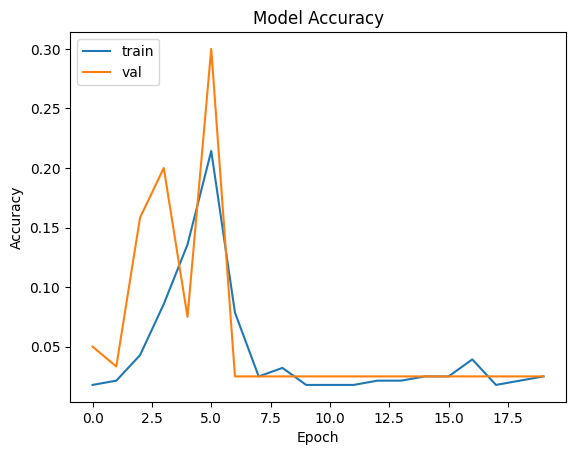

In [79]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


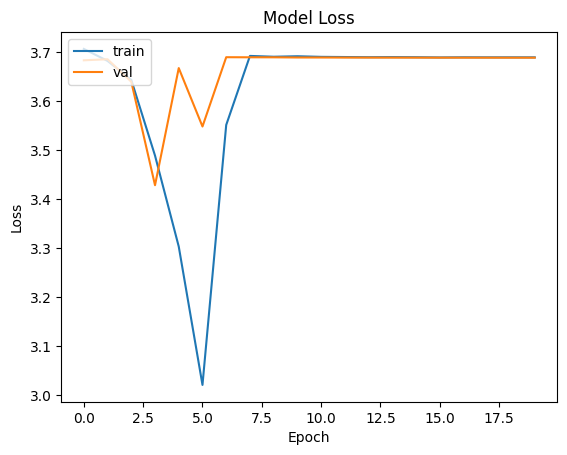

In [80]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [82]:
#final evaluation of the model

scores=cnn_model.evaluate(valid_data, verbose=0)
print("Accuracy = %.2f%% " % (scores[1]*100))


Accuracy = 2.50% 


4/4 [==============================] - 9s 2s/step


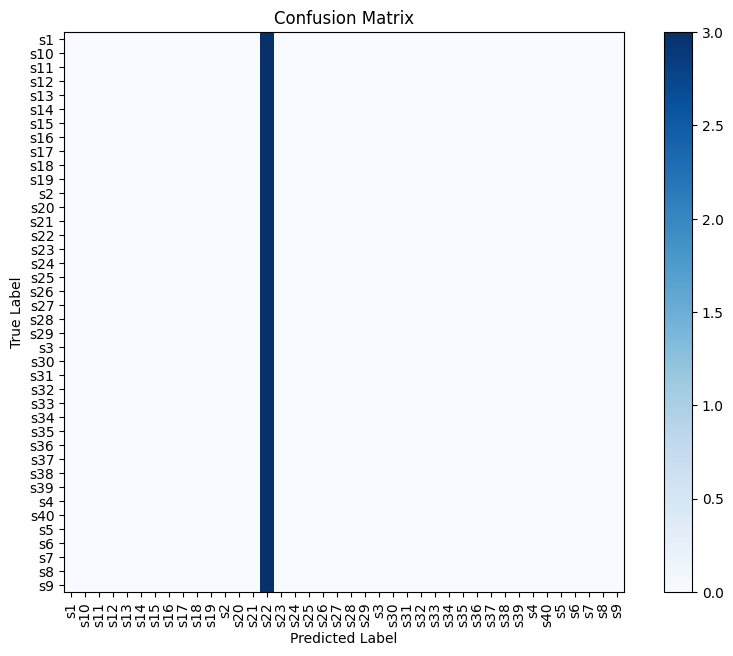

              precision    recall  f1-score   support

          s1       0.00      0.00      0.00         3
         s10       0.00      0.00      0.00         3
         s11       0.00      0.00      0.00         3
         s12       0.00      0.00      0.00         3
         s13       0.00      0.00      0.00         3
         s14       0.00      0.00      0.00         3
         s15       0.00      0.00      0.00         3
         s16       0.00      0.00      0.00         3
         s17       0.00      0.00      0.00         3
         s18       0.00      0.00      0.00         3
         s19       0.00      0.00      0.00         3
          s2       0.00      0.00      0.00         3
         s20       0.00      0.00      0.00         3
         s21       0.00      0.00      0.00         3
         s22       0.03      1.00      0.05         3
         s23       0.00      0.00      0.00         3
         s24       0.00      0.00      0.00         3
         s25       0.00    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
# building Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions for the validation set
y_pred = cnn_model.predict(valid_data)
y_pred = np.argmax(y_pred, axis=1)

# Get true labels for the validation set
y_true = valid_data.classes

# Get the class names
class_names = list(valid_data.class_indices.keys())

# Build the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title('Confusion Matrix')
plt.colorbar(im)
tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names, rotation=90)
ax.set_yticklabels(class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9)
plt.show()

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


In [66]:
# Creating another neural network to analyse change in accuracy and loss

from keras.layers import BatchNormalization

# Initializing a Sequential Model
cnn_model_2 = Sequential()

# Add the first Convolutional block
cnn_model_2.add(Conv2D(filters = 96, kernel_size = (11,11), strides =(4,4), padding = 'same', activation = 'relu', input_shape = (227,227,3)))
cnn_model_2.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
cnn_model_2.add (BatchNormalization())

# Add the second Convolutional block
cnn_model_2.add(Conv2D(filters = 256, kernel_size = (5,5), strides =(1,1), padding = 'same', activation = 'relu'))
cnn_model_2.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
cnn_model_2.add (BatchNormalization())

# Add the third Convolutional block
cnn_model_2.add(Conv2D(filters = 384, kernel_size = (3,3), strides =(1,1), padding = 'same', activation = 'relu'))

# Add the fourth Convolutional block
cnn_model_2.add(Conv2D(filters = 256, kernel_size = (3,3), strides =(1,1), padding = 'same', activation = 'relu'))
cnn_model_2.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))

# Add the Flatten layer
cnn_model_2.add(Flatten())

# Add the Dense layers
cnn_model_2.add(Dense(units = 4096, activation = 'relu'))
cnn_model_2.add(Dropout(0.5))
cnn_model_2.add(Dense(units = 4096, activation = 'relu'))
cnn_model_2.add(Dropout(0.5))

# Add the Final layer
cnn_model_2.add(Dense(units = 40, activation = 'softmax'))

# Compile the model
cnn_model_2.compile(optimizer='adam',  loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
cnn_model_2.summary()




Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 57, 57, 96)        34944     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 28, 28, 96)       0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Batc  (None, 28, 28, 96)       384       
 hNormalization)                                                 
                                                                 
 conv2d_29 (Conv2D)          (None, 28, 28, 256)       614656    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 13, 13, 256)      0         
 g2D)                                                            
                                                      

In [67]:
# fitting the model

history_2 = cnn_model_2.fit(train_data, validation_data = (valid_data), epochs=30, batch_size=32)

Epoch 1/10
9/9 [==============================] - 35s 4s/step - loss: 7.6597 - accuracy: 0.0071 - val_loss: 3.6895 - val_accuracy: 0.0250
Epoch 2/10
9/9 [==============================] - 33s 4s/step - loss: 3.6907 - accuracy: 0.0214 - val_loss: 3.6901 - val_accuracy: 0.0250
Epoch 3/10
9/9 [==============================] - 31s 3s/step - loss: 3.6918 - accuracy: 0.0286 - val_loss: 3.6902 - val_accuracy: 0.0250
Epoch 4/10
9/9 [==============================] - 31s 3s/step - loss: 3.6913 - accuracy: 0.0286 - val_loss: 3.6899 - val_accuracy: 0.0250
Epoch 5/10
9/9 [==============================] - 33s 4s/step - loss: 3.6915 - accuracy: 0.0250 - val_loss: 3.6895 - val_accuracy: 0.0250
Epoch 6/10
9/9 [==============================] - 39s 4s/step - loss: 3.6908 - accuracy: 0.0214 - val_loss: 3.6894 - val_accuracy: 0.0250
Epoch 7/10
9/9 [==============================] - 37s 4s/step - loss: 3.6910 - accuracy: 0.0250 - val_loss: 3.6892 - val_accuracy: 0.0250
Epoch 8/10
9/9 [==================

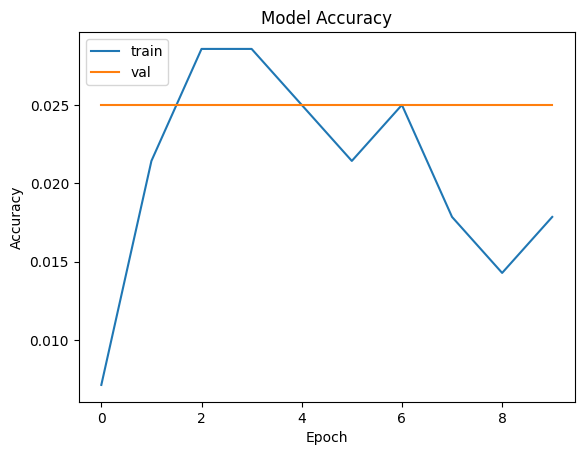

In [68]:
# Plot the training and validation accuracy
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

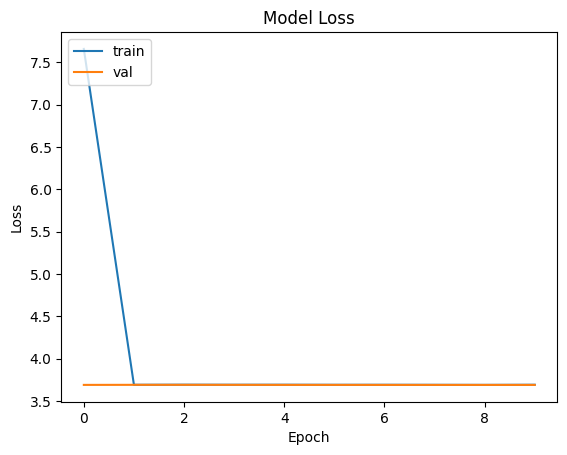

In [69]:
# Plot the training and validation loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [70]:
#final evaluation of the model

scores=cnn_model_2.evaluate(valid_data, verbose=0)
print("Accuracy = %.2f%% " % (scores[1]*100))

Accuracy = 2.50% 


4/4 [==============================] - 3s 688ms/step


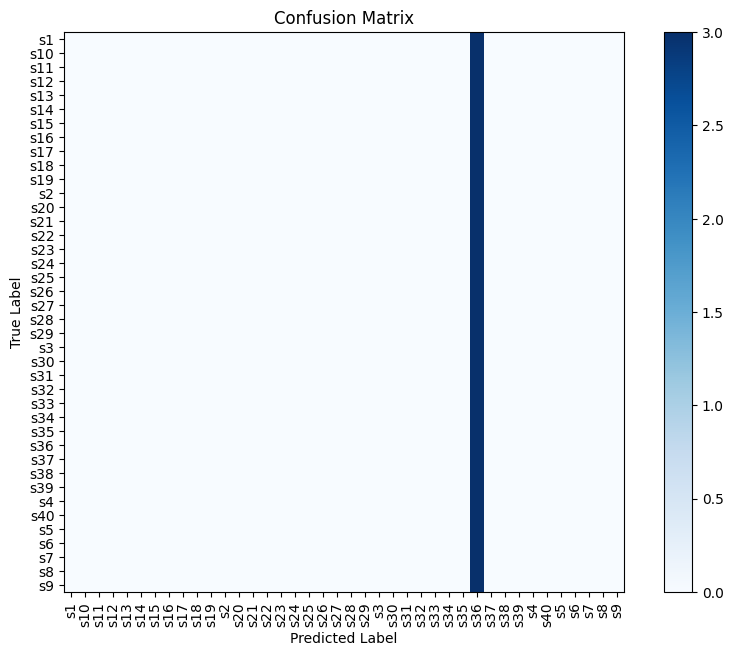

              precision    recall  f1-score   support

          s1       0.00      0.00      0.00         3
         s10       0.00      0.00      0.00         3
         s11       0.00      0.00      0.00         3
         s12       0.00      0.00      0.00         3
         s13       0.00      0.00      0.00         3
         s14       0.00      0.00      0.00         3
         s15       0.00      0.00      0.00         3
         s16       0.00      0.00      0.00         3
         s17       0.00      0.00      0.00         3
         s18       0.00      0.00      0.00         3
         s19       0.00      0.00      0.00         3
          s2       0.00      0.00      0.00         3
         s20       0.00      0.00      0.00         3
         s21       0.00      0.00      0.00         3
         s22       0.00      0.00      0.00         3
         s23       0.00      0.00      0.00         3
         s24       0.00      0.00      0.00         3
         s25       0.00    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions for the validation set
y_pred = cnn_model_2.predict(valid_data)
y_pred = np.argmax(y_pred, axis=1)

# Get true labels for the validation set
y_true = valid_data.classes

# Get the class names
class_names = list(valid_data.class_indices.keys())

# Build the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title('Confusion Matrix')
plt.colorbar(im)
tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names, rotation=90)
ax.set_yticklabels(class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9)
plt.show()

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


Epoch 1/20
9/9 [==============================] - 232s 27s/step - loss: 10.7430 - accuracy: 0.0286 - val_loss: 4.0397 - val_accuracy: 0.0250
Epoch 2/20
9/9 [==============================] - 230s 27s/step - loss: 3.6909 - accuracy: 0.0536 - val_loss: 3.4754 - val_accuracy: 0.1167
Epoch 3/20
9/9 [==============================] - 201s 23s/step - loss: 3.5959 - accuracy: 0.0607 - val_loss: 3.6121 - val_accuracy: 0.0333
Epoch 4/20
9/9 [==============================] - 222s 26s/step - loss: 3.5660 - accuracy: 0.0500 - val_loss: 3.3840 - val_accuracy: 0.0583
Epoch 5/20
9/9 [==============================] - 215s 25s/step - loss: 3.5910 - accuracy: 0.0500 - val_loss: 3.5725 - val_accuracy: 0.0500
Epoch 6/20
9/9 [==============================] - 201s 23s/step - loss: 3.5335 - accuracy: 0.0786 - val_loss: 3.4168 - val_accuracy: 0.2083
Epoch 7/20
9/9 [==============================] - 223s 26s/step - loss: 3.4452 - accuracy: 0.0750 - val_loss: 3.3343 - val_accuracy: 0.1250
Epoch 8/20
9/9 [===

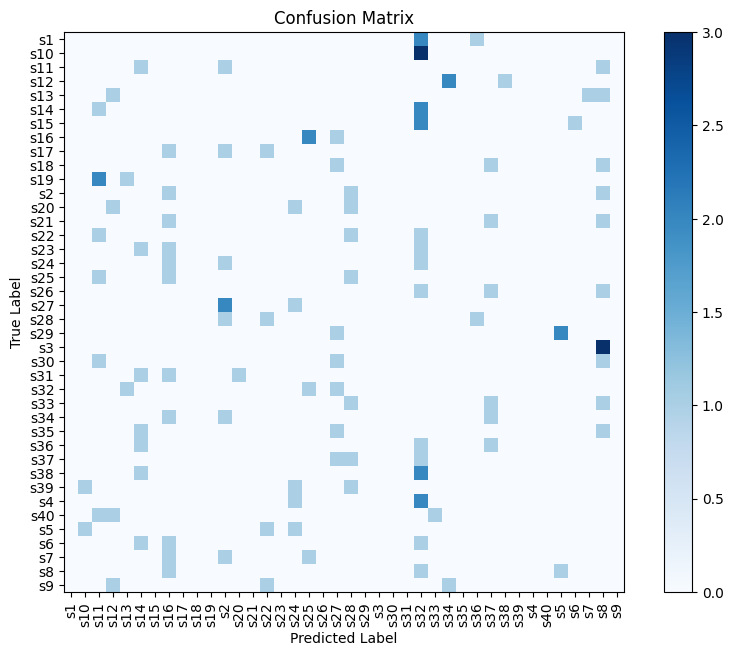

              precision    recall  f1-score   support

          s1       0.00      0.00      0.00       3.0
         s10       0.00      0.00      0.00       3.0
         s11       0.00      0.00      0.00       3.0
         s12       0.00      0.00      0.00       3.0
         s13       0.00      0.00      0.00       3.0
         s14       0.00      0.00      0.00       3.0
         s15       0.00      0.00      0.00       3.0
         s16       0.00      0.00      0.00       3.0
         s17       0.00      0.00      0.00       3.0
         s18       0.00      0.00      0.00       3.0
         s19       0.00      0.00      0.00       3.0
          s2       0.00      0.00      0.00       3.0
         s20       0.00      0.00      0.00       3.0
         s21       0.00      0.00      0.00       3.0
         s22       0.00      0.00      0.00       3.0
         s23       0.00      0.00      0.00       3.0
         s24       0.00      0.00      0.00       3.0
         s25       0.00    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
# Repeating the above with a VGG 19 as per the question in assignment
from keras.applications import VGG19

num_classes = 40

# Load the VGG19 model
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(227, 227, 3))

# Freeze the layers of the VGG19 model
for layer in vgg_model.layers:
    layer.trainable = False

# Create a new model on top of the VGG19 model
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, epochs=epochs, validation_data=valid_data)

# Evaluate the model
scores = model.evaluate(valid_data, verbose=0)
print("Accuracy = %.2f%% " % (scores[1]*100))

# Generate predictions for the validation set
y_pred = model.predict(valid_data)
y_pred = np.argmax(y_pred, axis=1)

# Get true labels for the validation set
y_true = valid_data.classes

# Get the class names
class_names = list(valid_data.class_indices.keys())

# Build the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title('Confusion Matrix')
plt.colorbar(im)
tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names, rotation=90)
ax.set_yticklabels(class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9)
plt.show()

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


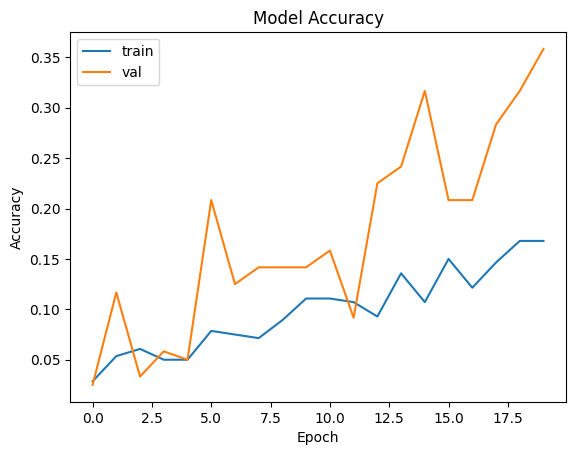

In [74]:
# Plot the training and validation accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

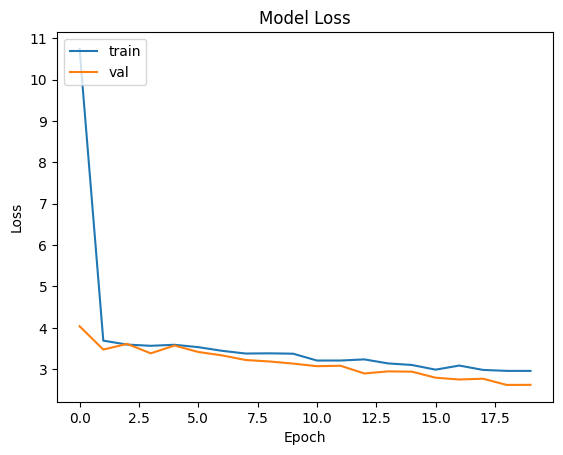

In [75]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
